<a href="https://colab.research.google.com/github/compartia/nlp_tools/blob/tensorflow-model-tokens/TF_wordpieces%2C_augmentation%2C_NER%2C_Struct_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
GLOBALS__={}

## MAIN, init, load code

In [0]:
#@title  { form-width: "300px", display-mode: "form" }
import os

!pip install sentencepiece
import sentencepiece as spm




# ''' AZ:-IMPORT CODE GITHUB----------------------------------------------😺------ '''
import sys
# ====================================
# ====================================
_git_branch = "tensorflow-model-tokens"  # @param {type:"string"}
# ====================================
# ====================================


def _init_import_code_from_gh():
  if 'GLOBALS__' not in globals():
    print('adding global GLOBALS__')
    global GLOBALS__
    GLOBALS__ = {}

  if '_init_import_code_from_gh' in GLOBALS__:
    print('👌 code already imported from GitHub!')
    return

  import subprocess
  def exec(x):
    r = subprocess.check_output(x, shell=True)
    r = r.decode('unicode-escape').encode('latin1').decode('utf8')
    print(r)

  print(f"fetching code from GitHub.....{_git_branch}")
  try:
    exec('rm -r nlp_tools')
  except:
    pass
  exec(f'git clone --single-branch --branch {_git_branch} https://github.com/compartia/nlp_tools.git nlp_tools')

  print('🦊 GIT revision:')
  exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

  sys.path.insert(0, 'nlp_tools')

  # self-test

  print('installing antiword...')
  exec('sudo apt-get install antiword')

  print('installing docx2txt...')
  exec("pip install docx2txt")

  GLOBALS__['_init_import_code_from_gh'] = True

  ''' AZ:-------------------------------------------------IMPORT CODE GITHUB-😺---'''
  print('❤️ DONE importing Code fro GitHub')


# AZ:-INIT ELMO-----------------------------------------------------------------------------------

import tensorflow_hub as hub

#
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


 

# AZ:- THE CODE----------------------------------------------------------------------------------

def _init_the_code(reset=False):
  if '_init_the_code' in GLOBALS__ and not reset:
    print('👌 Code is alredy imported!')
    return

  from renderer import HtmlRenderer
  from renderer import to_multicolor_text
  from renderer import known_subjects_dict

  from structures import ContractSubject
  from contract_parser import ContractDocument3

  from ml_tools import ProbableValue

  from legal_docs import LegalDocument
  from renderer import as_warning, as_headline_3, as_offset, as_smaller

  class DemoRenderer(HtmlRenderer):

    def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      html = self.to_color_text(tokens, weights, colormap, print_debug, _range)
      display(HTML(html))

    def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range)

    def render_multicolor_text(self, tokens, vectors, colormap, min_color=None, _slice=None):
      display(HTML(to_multicolor_text(tokens, vectors, colormap, min_color=min_color, _slice=_slice)))

     
     

     
  GLOBALS__['renderer'] = DemoRenderer()

  GLOBALS__['_init_the_code'] = True
  print("❤️ DONE initializing the code")

  # AZ:-------------------------------------------------Init Protocols context===


def read_doc(fn):
  import docx2txt, sys, os

  text = ''
  try:
    text = docx2txt.process(fn)

  except:
    print("Unexpected error:", sys.exc_info())
    os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
    with open(fn + '.txt') as f:
      text = f.read()

  return text

def interactive_upload(filetype):
  from google.colab import files
  import docx2txt

  print(f'Please select "{filetype}" .docx file:')
  uploaded = files.upload()
  docs = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    with open(fn, "wb") as df:
      df.write(uploaded[fn])
      df.close()

    # extract text

    text = ''
    try:
      text = docx2txt.process(fn)
    except:
      print("Unexpected error:", sys.exc_info())
      os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
      with open(fn + '.txt') as f:
        text = f.read()
    print("Символов в оригинальном документе:", len(text))
    docs.append(text)
    return docs

  
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXX


# 1.
_init_import_code_from_gh()
 
# 3.
_init_the_code(True)



fetching code from GitHub.....tensorflow-model-tokens


🦊 GIT revision:
469
* tensorflow-model-tokens
Created using Colaboratory
Augmentation: uppercase all

Augmentation: no case altering


installing antiword...
Reading package lists...
Building dependency tree...
Reading state information...
antiword is already the newest version (0.37-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.

installing docx2txt...

❤️ DONE importing Code fro GitHub
❤️ DONE initializing the code


# Prepare train set
### ACHTUNG: DO NOT EDIT: this section is a COPY of https://colab.research.google.com/drive/1XcuIjt5lUvuXc2PYCGzwSavA15qrOwQw#scrollTo=5w1tSGLqn7hM&uniqifier=32

## Разметка договоров ( regEx)
 - чтение докуметов
 - поиск по шаблонам (org name, org type, org alias, etc)
 - формирование one-hot векторов (матрицы), она будет использована в TF(keras?) модели как labels

### 📂👤Load files from GDrive

In [0]:

from google.colab import auth
from google.colab import drive
 

drive.mount('/content/gdrive', force_remount=True)


import glob
def read_documents(filename_prefix):
  texts = {}
  for file in glob.glob(filename_prefix+"*.doc"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.doc FILE!!', file)

  for file in glob.glob(filename_prefix+"*.docx"):
    try:
      text = read_doc(file)
      texts[file] = text
      print("good:", file)
    except:
      print('WRONG *.docx FILE!!', file)
      
  return texts

contracts_filename_prefix='/content/gdrive/My Drive/GazpromOil/Contracts/'
contracts = read_documents(contracts_filename_prefix)


assert len(contracts) > 0


Mounted at /content/gdrive
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f7e7702ba88>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора ООО Чудеса.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f7e7702bf88>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Доп.согл3 Доверие.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f7e7702bf48>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора ООО Зеленые.doc
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f7e7702b148>)
good: /content/gdrive/My Drive/GazpromOil/Contracts/Договор купли-продажи_ООО Парацельс.doc
Unexpected error: (<class 'KeyError'>, KeyEr

### Build dictionary


In [0]:
# !pip install sentencepiece
# import sentencepiece as spm
DICT_SIZE=2000

In [0]:
#raise 'stop, dont kill the dict'

#join texts
_all_contracts='\n\n\n\n'.join(contracts.values())


with open('_all_contracts.txt', 'w') as file:
  file.write(_all_contracts)


  
# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
spm.SentencePieceTrainer.train(f'--input=_all_contracts.txt --model_prefix=m --vocab_size={DICT_SIZE}')

True

In [0]:
# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

# encode: text => id
_text='''
Лихо Рыбу
мыл Вадим
'''
tokens = sp.encode_as_pieces(_text)
print(tokens)
print(sp.decode_pieces(tokens))


['▁', 'Л', 'их', 'о', '▁Р', 'ы', 'б', 'у', '▁', 'м', 'ы', 'л', '▁В', 'а', 'д', 'им']
Лихо Рыбу мыл Вадим


In [0]:
_s=list(contracts.values())[0][300:400] 
print(sp.encode_as_pieces( _s))


['▁|', '▁О', 'бщество', '▁с', '▁ограничен', 'ной', '▁ответственность', 'ю', '▁«', 'Газпромнефть', '-', 'К', 'ор', 'по', 'р', 'а', 'ти', 'в']


In [0]:
for n in range(10):
  print(sp.sample_encode_as_pieces(_s, -1, 0.1))

['▁', '|', '▁О', 'бщество', '▁с', '▁', 'о', 'г', 'р', 'а', 'ни', 'ч', 'е', 'н', 'но', 'й', '▁от', 'в', 'ет', 'с', 'т', 'в', 'ен', 'н', 'о', 'с', 'ть', 'ю', '▁«', 'Газпромнефть', '-', 'К', 'ор', 'п', 'о', 'р', 'а', 'ти', 'в']
['▁|', '▁О', 'б', 'ществ', 'о', '▁с', '▁о', 'г', 'р', 'ан', 'и', 'ч', 'ен', 'н', 'ой', '▁о', 'тветственность', 'ю', '▁«', 'Г', 'а', 'з', 'п', 'р', 'ом', 'не', 'ф', 'ть', '-', 'К', 'ор', 'п', 'ор', 'а', 'т', 'и', 'в']
['▁|', '▁Общ', 'е', 'ство', '▁с', '▁', 'огранич', 'ен', 'ной', '▁ответственность', 'ю', '▁«', 'Газпромнефть', '-', 'К', 'ор', 'п', 'о', 'р', 'а', 'т', 'и', 'в']
['▁', '|', '▁О', 'бщество', '▁с', '▁о', 'г', 'р', 'ан', 'и', 'ч', 'ен', 'ной', '▁ответ', 'ст', 'в', 'е', 'н', 'но', 'сть', 'ю', '▁«', 'Газпромнефть', '-', 'К', 'о', 'р', 'п', 'о', 'р', 'а', 'т', 'и', 'в']
['▁|', '▁', 'О', 'бщество', '▁с', '▁', 'огранич', 'е', 'н', 'ной', '▁ответ', 'ст', 'в', 'е', 'н', 'н', 'о', 'сть', 'ю', '▁«', 'Газпромнефть', '-', 'К', 'ор', 'п', 'о', 'р', 'а', 'ти', 'в']
['▁

In [0]:
print(sp.decode_ids([999, 777, 555, 444, 111, 222, 333]))

Арендодателематель надлежащим стоимость 1ки Работ


### Rendering utils

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

_c_cyan1=(0, 1, 0.6)
_c_orange1=(1, 0.7, 0)
_c_green1=(0.3, 1, 0)
_c_pink1=(0.3, 0, 1)

_c_cyan2=(0, 0.8, 0.6)
_c_orange2=(1, 0.6, 0)
_c_green2=(0.4, 1, 0)
_c_pink2=(0.4, 0, 1)

token_colors=[
    (0.5, 0.5, 0.5),#undefined
    
    _c_cyan1,
    _c_orange1,
    _c_green1,
    _c_pink1,
    _c_pink1,
    
    _c_cyan2,
    _c_orange2,
    _c_green2,
    _c_pink2,
    _c_pink2,
    
    (0.1, 0.3, 1)#headlines
]

_colormap={}
for k in range(20):
  key = f'c{k}'
  _colormap[key] = token_colors[ k % len(token_colors) ]
    
    
def color_matrix(matrix, tokens):
    
  mt = matrix.T
  vectors = {}

  for k in range( int(matrix.shape[1])):

    key = f'c{k}'
    _colormap[key] = token_colors[ k % len(token_colors) ]
    vectors[key] = mt[k]
  
 
  GLOBALS__['renderer'].render_multicolor_text(tokens, vectors, _colormap, min_color=(0.4, 0.4, 0.4) )
  
  
  
  
  
##------------
def plot_matrix(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 3))
    ax = sns.heatmap(mt, square=False,  cmap="YlGnBu")
    plt.show()


### Parsing, etc

In [0]:
!pip install rstr

import numpy as np
import rstr

from contract_parser import ContractDocument3
from trainset_builder import *

#### 💀Test

In [0]:
contract_text = list(contracts.values())[1] 
doc = ContractDocument3(contract_text)
doc.parse()
 
for hi in doc.structure.headline_indexes:
  s = doc.structure.structure[hi]
  print (s.span, doc.tokens_cc[slice(s.span[0],s.span[1])])
  
headlines_markup_vector =  np.zeros( doc.get_len()  )
mark_headlines(doc, headlines_markup_vector , 1)
 
GLOBALS__['renderer'].render_color_text(doc.tokens_cc, headlines_markup_vector   )

(0, 65) ['Д', 'О', 'П', 'О', 'Л', 'Н', 'И', 'ТЕЛЬ', 'Н', 'О', 'Е', ' С', 'О', 'Г', 'Л', 'А', 'Ш', 'Е', 'Н', 'И', 'Е', ' №', '3', '\n', '\n', 'К', ' ДОГОВОР', 'У', ' О', ' В', 'Ы', 'Д', 'А', 'Ч', 'Е', ' БАНКОВСКИ', 'Х', ' ', 'ГАРАНТ', 'И', 'Й', '.', '\n', '\n', 'ОТ', ' ', '0', '6', ' ', 'Ф', 'Е', 'В', 'Р', 'А', 'Л', 'Я', ' 20', '1', '3', ' Г', 'О', 'Д', 'А', '.', '\n']
(279, 288) ['1.', ' Стороны', ' при', 'ш', 'ли', ' к', ' соглашению', ':', '\n']
(1228, 1242) ['4.', ' Настоящ', 'е', 'е', ' Дополнительно', 'е', ' соглашение', ' является', ' неотъемлем', 'ой', ' частью', ' Договора', '.', '\n']


#### 💀Test `_to_categories_vector`

In [0]:
from trainset_builder import _to_categories_vector
to_categories_vector = _to_categories_vector

### TESTS 🔞============✂️============⚙️========================================


doc = preprocess_contract(list(contracts.values())[4])
find_org_names_spans(doc)

print(doc.agent_infos)

categories_vector = _to_categories_vector(doc)

# plot_matrix(categories_vector)
GLOBALS__['renderer'].render_color_text(doc.tokens_cc[0:400], categories_vector[0:400])


[{'type': ('Акционерное общество', (128, 148), slice(34, 38, None)), 'name': ('ХранТрансНефть', (150, 164), slice(39, 40, None)), 'alt_name': ('(АО "ХранТрансНефть")', (166, 187), slice(41, 46, None)), 'alias': (None, None, None), 'type_ext': (' ', (148, 149), slice(38, 38, None))}, {'type': ('Акционерное общество', (343, 363), slice(100, 104, None)), 'name': ('Мессояханефтегаз', (365, 381), slice(105, 106, None)), 'alt_name': ('(АО "Мессояханефтегаз")', (383, 406), slice(107, 112, None)), 'alias': (None, None, None), 'type_ext': (' ', (363, 364), slice(104, 104, None))}, {'type': ('АО', (12043, 12045), slice(3235, 3236, None)), 'name': ('ХранТрансНефть – Сибирь', (12047, 12070), slice(3237, 3245, None)), 'alt_name': ('', (12089, 12089), slice(3246, 3246, None)), 'alias': (None, None, None), 'type_ext': (' ', (12045, 12046), slice(3236, 3236, None))}, {'type': ('АО', (12140, 12142), slice(3259, 3260, None)), 'name': ('ХранТрансНефть – Центральная Сибирь', (12144, 12179), slice(3261, 32

#### 💀 Test `categories_vector_to_onehot_matrix`

(6909, 12) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


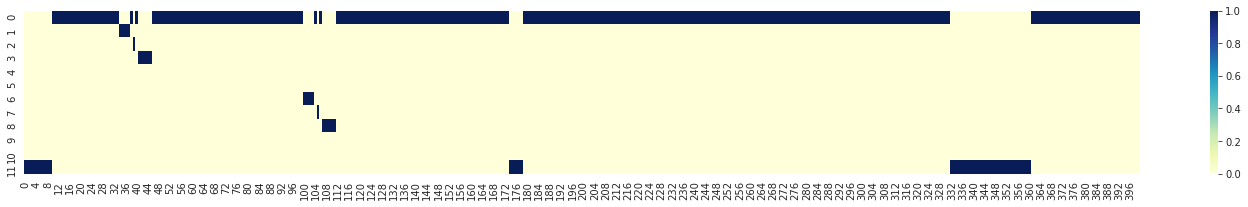

In [0]:
m = categories_vector_to_onehot_matrix(categories_vector, height=11,  add_none_category=True)
print(m.shape, m[0])

_slice = slice(0,400)
color_matrix(m[_slice], doc.tokens_cc[_slice])
plot_matrix(m[_slice])
 

### CSV export methods

In [0]:
# len(categories_vector)

import csv


csv_path = '/content/gdrive/My Drive/GazpromOil/Contracts/augmented_cropped_CSVs/'
txt_path = csv_path + 'txt/'

def to_csv(contract_tokens, categories_vector, filename):
  with open(filename+'.csv', mode='w') as csv_file:
    _writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for k in range(len(categories_vector)):
      _writer.writerow([contract_tokens[k], int(categories_vector[k])])
      
      
def save_as_text(contract_tokens,  filename):
  with open(filename+'.txt', mode='w') as txt_file:
    txt_file.write( untokenize(contract_tokens))
    
 

def save_entities_types(filename):
  with open(filename+'.csv', mode='w') as csv_file:
    _writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    _writer.writerow(['id', 'class'])
    
    _writer.writerow([0, 'unknown'])
    
    k=0
    for agent_n in range(1, 3):
      for entity_type in entities_types:
        _writer.writerow([k+1, f'org{agent_n} ' + entity_type ])
        k+=1
    
     
save_as_csv = to_csv #aliasing

save_entities_types(csv_path + 'classes-dict')

### Augmentaion

In [0]:

# ### TESTS 🔞============✂️============⚙️========================================
# normalized_contract = preprocess_contract( list(contracts.values())[2] )


# org_infos = find_org_names(normalized_contract)
# print (org_infos)
# obfuscated_contract, org_infos = obfuscate_contract(normalized_contract, org_infos, 1 )
# del normalized_contract
# org_infos, contract_tokens = convert_char_slices_to_tokens(obfuscated_contract,  org_infos)
# categories_vector = make_categories_vector(org_infos, len(contract_tokens)).T



# print(untokenize(contract_tokens))
# print("="*150)
# # new_tokens, new_categories_vector = dropout_words(contract_tokens, categories_vector, 0.5)

# new_tokens, new_categories_vector = augment_contract(contract_tokens, categories_vector)
 
 
# m = categories_vector_to_onehot_matrix(new_categories_vector)
# color_matrix(m, new_tokens)


from contract_augmentation import *

### TESTS 🔞============✂️============⚙️========================================
from trainset_builder import preprocess_contract, categories_vector_to_onehot_matrix, _to_categories_vector

doc = preprocess_contract(list(contracts.values())[3])
find_org_names_spans(doc)

print(doc.agent_infos)



# org_infos = find_org_names(doc)
# print(org_infos)
obfuscated_contract = obfuscate_contract(doc, 1)
print(obfuscated_contract.agent_infos)

# org_infos, contract_tokens = convert_char_slices_to_tokens(doc, org_infos)
# categories_vector = make_categories_vector(org_infos, len(contract_tokens)).T
categories_vector = _to_categories_vector(obfuscated_contract)
 
  
new_tokens, new_categories_vector = augment_contract(obfuscated_contract.tokens_cc, categories_vector)

_slice = slice(0,500)

m = categories_vector_to_onehot_matrix(new_categories_vector, height=11, add_none_category=True)
color_matrix(m[_slice], new_tokens[_slice])

# m = categories_vector_to_onehot_matrix(categories_vector)
# color_matrix(m, new_tokens)

[{'type': ('Акционерное общество', (95, 115), slice(24, 28, None)), 'name': ('Мессояханефтегаз', (117, 133), slice(29, 30, None)), 'alt_name': ('', (134, 134), slice(30, 30, None)), 'alias': ('Продавец', (254, 262), slice(62, 63, None)), 'type_ext': (' ', (115, 116), slice(28, 28, None))}, {'type': ('ООО', (284, 287), slice(70, 71, None)), 'name': ('Парацельс', (289, 298), slice(72, 79, None)), 'alt_name': ('', (300, 300), slice(80, 80, None)), 'alias': ('Покупатель', (419, 429), slice(119, 120, None)), 'type_ext': (' ', (287, 288), slice(71, 71, None))}]
[{'type': ('Некоммерческая организация', (63, 89), slice(24, 30, None)), 'name': ('Ббобаеж бвбаов годбп', (91, 111), slice(31, 48, None)), 'alt_name': ('', (112, 112), slice(48, 48, None)), 'alias': ('Игждж', (232, 237), slice(80, 85, None)), 'type_ext': (' ', (89, 90), slice(30, 30, None))}, {'type': ('Благотворительный фонд', (259, 281), slice(92, 98, None)), 'name': ('Егжабоп гжгагб', (283, 297), slice(99, 112, None)), 'alt_name': 

## Building trainset

In [0]:

# def random_samples(num, size, __vectors, __tokenized_texts):
#   well_sized = []
#   well_sized_vectors = []
#   for n in range(len(__tokenized_texts)):
#     if len(__tokenized_texts[n]) >= size:
#       well_sized.append(__tokenized_texts[n])
#       well_sized_vectors.append(__vectors[n])

#   pieces = []
#   vectors = []

#   for n in range(num):
#     random_index = random.randint(0, len(well_sized) - 1)
#     txt = well_sized[random_index]
#     vec = well_sized_vectors[random_index]

#     wnd = random_widow(size, len(txt) - 1)

#     piece = txt[wnd]
#     vector = vec[wnd]

#     vectors.append(vector)
#     pieces.append(piece)

#   pieces, _lengths, _padded_vectors = add_padding_to_max(pieces, vectors)
#   _labels = categories_vectors_to_onehot_matrices(_padded_vectors, 12)

#   return pieces, _labels, _lengths


# def trim_vectors_to_size(_vectors: List, size: int):
#   _vectors_trimmed = []

#   for n in range(len(_vectors)):
#     _vectors_trimmed.append(_vectors[n][0:size])
#   return _vectors_trimmed
    

# def _prepare_train_data_pieces(num, size, contracts, augmenented_n=5, obfuscated_n=3, include_originals=True):
#   _vectors, _tokenized_texts, _failed = mark_contracts(contracts, augmenented_n, obfuscated_n, trim=0,
#                                                        include_originals=include_originals)

#   print('number of augmened contracts =', len(_tokenized_texts))

#   _vectors_trimmed = trim_vectors_to_size(_vectors, size * 2)
#   _tokenized_texts_trimmed = trim_vectors_to_size(_tokenized_texts, size * 2)

#   pieces, _labels, _lengths = random_samples(num, size, _vectors_trimmed, _tokenized_texts_trimmed)

#   return pieces, _labels, _lengths, _failed

In [0]:

OBFUSCATED=3
AUGMENTED=7

FRAGMENT_SIZE=1024

_TEXTS, _LABELS, _LENS, FAILED = prepare_train_data_pieces(1024, FRAGMENT_SIZE, contracts, obfuscated_n=OBFUSCATED, augmenented_n=AUGMENTED, include_originals=False )

 

np_LABELS=_LABELS #alias


print('*'*150)
print('len (_TEXTS)=', len(_TEXTS))
print('max (_LENS)=', max(_LENS))
print('_LABELS[0].shape=', _LABELS[0].shape)


_slice = slice(0,FRAGMENT_SIZE)
for m in random.choices( range(len(_LABELS)), k=10):
  print("="*150)
  color_matrix(_LABELS[m][_slice], _TEXTS[m][_slice])

 

failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Доп.согл3 Доверие.doc
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Договор хранения нефти_ХранТрансНефть.doc
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/7. Соглашение БГ Газпромнефть-Региональные продажи.doc
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Договор_ООО Зодчий_25 млн.$.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/ДКП Половинной НБ и АЗС.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/1. Доп. соглашение к Договору_фин.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Проект договора Пур адм.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Договор 2.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/Договор выполнения работ_Петров.docx
failed parsing: /content/gdrive/My Drive/GazpromOil/Contracts/1.1. Договор пожертвования.docx
failed parsing: /content/gdrive/My Drive/Gazp

In [0]:
_slice = slice(0,300)
for m in random.choices( range(len(_LABELS)), k=10):
  print("="*150)
  color_matrix(_LABELS[m][_slice], _TEXTS[m][_slice])

In [0]:
# _vectors, _tokenized_texts, _failed = mark_contracts(contracts, obfuscated_n=OBFUSCATED, augmenented_n=AUGMENTED, trim=0, include_originals=False)


In [0]:
# _TEXTS, _LABELS, _LENS, FAILED = prepare_train_data_pieces(10, 500, contracts, obfuscated_n=1, augmenented_n=2, include_originals=False )


# _TEXTS, _LABELS, _LENS = split_texts_into_random_pieces(4096, 512, _vectors, _tokenized_texts)

# np_LABELS=_LABELS #alias


# print('*'*150)
# print('len (_TEXTS)=', len(_TEXTS))
# print('max (_LENS)=', max(_LENS))
# print('_LABELS[0].shape=', _LABELS[0].shape)


# _slice = slice(0,300)
# for m in random.choices( range(len(_LABELS)), k=10):
#   print("="*150)
#   color_matrix(_LABELS[m][_slice], _TEXTS[m][_slice])


### Набор для  органолептической (глазо-ручной) оценки 😱результатов обучения
Это документы, на которых regEx провалились, эти доки модель (мадам) не видела при обучении

In [0]:
def prepare_validation_data(FAILED):
  tokenss=[]
  for doc in FAILED:
    tokenss.append(doc.tokens_cc)

  tokenss, lens, _ = add_padding_to_max(tokenss)
  return  tokenss, lens 


VAL_TOKENS, VAL_LENS = prepare_validation_data(FAILED)

# @deprecated
# TEST_TOKENS = tokenize_text( preprocess_contract(contracts['/content/gdrive/My Drive/GazpromOil/Contracts/Проект договора Пур адм - благотв.docx']))

# #####
# VAL_TOKENS, VAL_LENS = prepare_validation_data(FAILED, contracts)

_lengths= [1312, 6909, 10703, 34425, 3915, 1148, 1321, 3319, 6849, 1091, 1305, 3954, 1124, 2777, 5021, 1056, 1051]


In [0]:
FAILED_names=[f.filename for f in FAILED]
FAILED_names

['/content/gdrive/My Drive/GazpromOil/Contracts/Доп.согл3 Доверие.doc',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор хранения нефти_ХранТрансНефть.doc',
 '/content/gdrive/My Drive/GazpromOil/Contracts/7. Соглашение БГ Газпромнефть-Региональные продажи.doc',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор_ООО Зодчий_25 млн.$.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/ДКП Половинной НБ и АЗС.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/1. Доп. соглашение к Договору_фин.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Проект договора Пур адм.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор 2.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор выполнения работ_Петров.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/1.1. Договор пожертвования.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор 5.docx',
 '/content/gdrive/My Drive/GazpromOil/Contracts/Договор1.docx',
 '/content/gdrive/My Drive/GazpromOi

### Plot sample label  matrices

In [0]:
_slice = slice(0,300)
for m in random.choices( range(9,len(_LABELS)), k=10):
  print("="*150)
  color_matrix(_LABELS[m][_slice], _TEXTS[m][_slice])

# MODELS

## init

In [0]:
 

import os
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Concatenate, Input, Flatten, Conv1D, MaxPooling1D, Lambda, Add, BatchNormalization
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report

from IPython.display import SVG

In [0]:
EPOCHS = 32
BATCH_SIZE = 32

####  support  methods

In [0]:


def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  
HISTORIES={}

def plot_compare_models():
  for key in HISTORIES:
    history=HISTORIES[key]
#     plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key} val_loss')
  
  plt.title('Models loss')   
  plt.legend(loc='upper left')
  plt.show()
  


In [0]:
from keras.callbacks import Callback 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from keras import backend as K
from keras.objectives import categorical_crossentropy
from keras.optimizers import Adam
from keras.layers import LSTM, Flatten

model_checkpoint_path="/content/gdrive/My Drive/Colab Notebooks/checkpoints/"


def custom_categorical_crossentropy(x, y):
    x = K.flatten(x)
    y = K.flatten(y)
    return categorical_crossentropy(x, y)


def to_hashes(tokens):
  return np.array( [sp.piece_to_id(w) for w in tokens])


def validate_model_simple(model):

  texts = np.array([ to_hashes(t) for t in _TEXTS]) 
  val_texts = np.array([ to_hashes(t) for t in VAL_TOKENS]) 

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)
  checkpoint = ModelCheckpoint(model_checkpoint_path+model.name, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

  history = model.fit(texts, np_LABELS, validation_split=0.25, epochs=EPOCHS, batch_size=BATCH_SIZE,  callbacks=[reduce_lr, checkpoint])


  HISTORIES[model.name]=history
  plot_training_history(history)
  plot_compare_models()


  pred = model.predict([ val_texts   ])
  for p in range(len(pred)):
    print("*"*150)
    plot_matrix(pred[p][0:1500])
    color_matrix(pred[p][0:1500], VAL_TOKENS[p][0:1500])

 

In [0]:
 raise 'stop here please, it is going to train all models'

TypeError: ignored

## 1: 💔Custom Embeddings, emb  2000 x 8, loss 0.026, 

- Custom Embeddings 2000 x 8, 
- 3 слоя bideirectional GRU

#### checkpoint:
(/content/gdrive/My Drive/Colab Notebooks/checkpoints/wordpieces 3 bi-GRU emb=8x2000 SpatialDropout1D=0.1 l=6)

#### loss: 0.02687


- embedding_1 (Embedding)    |   (None, None, 8)     |      16000     

- spatial_dropout1d_1 | (Spatial (None, None, 8)    |       0         

- bidirectional_1 (Bidirection (None, None, 24)          1512      

- bidirectional_2 (Bidirection (None, None, 24)          2664      

- bidirectional_3 (Bidirection (None, None, 24)          2664        

- time_distributed_1 (TimeDist (None, None, 12)          300       




In [0]:
from keras.layers import GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Conv1D, Concatenate, SpatialDropout1D
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding
 
EPOCHS=20
BATCH_SIZE=50
EMB=8
 

def get_conv_pool(x_input, sufix, feature_maps, n=3, activation='relu'):
  branch = Conv1D( filters = feature_maps, kernel_size=(n), padding='same', activation=activation, name='Conv_'+sufix+'_'+str(n))(x_input)
  return branch


# _out = Dropout(0.1)(_out)
# _out = get_conv_pool(_out, 'relu-1', n=3, feature_maps=features, activation='relu') 


# _out = Bidirectional (GRU(features, return_sequences=True))(_out)
# _out = get_conv_pool(_out, 'relu-2', n=3, feature_maps=features, activation='relu') 

# _out = TimeDistributed(Dense(features, activation='softmax'))(_out)

def build_twin_gru_with_dense(features): 
  _dropout = 0.1
  model = Sequential()
  model.add(Embedding(DICT_SIZE, EMB))
  model.add(SpatialDropout1D(_dropout) )

  #model.add( Conv1D( filters = features, kernel_size=(3), padding='same', activation='relu' ))
#  model.add( Conv1D( filters = features, kernel_size=(3), padding='same', activation='relu' ))
  model.add( Bidirectional (GRU(features, return_sequences=True)))
  model.add( Bidirectional (GRU(features, return_sequences=True)))
  model.add( Bidirectional (GRU(features, return_sequences=True)))
#   l2 = GRU(features, return_sequences=True, go_backwards=True, name='reversed')(_out)   
     
#   model.add( Conv1D( filters = features, kernel_size=(3), padding='same', activation='relu' ))
#   model.add( BatchNormalization())
  model.add( TimeDistributed(Dense(features, activation='softmax')))
 
  model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
  model.summary()
  
 
  model.name=f'wordpieces 3 bi-GRU emb={EMB}x{DICT_SIZE} SpatialDropout1D={_dropout} l={len(model.layers)}'
  return model

 
model = build_twin_gru_with_dense( np_LABELS.shape[-1] )
model.name

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)

## 1.1: 💔Custom Embeddings, emb  2000 x 8, Dropout last

- Custom Embeddings 2000 x 8, 
- 3 слоя bideirectional GRU

#### checkpoint:
(/content/gdrive/My Drive/Colab Notebooks/checkpoints/wordpieces 3 bi-GRU emb=8x2000 SpatialDropout1D=0.1 l=6)

#### loss: 0.02687

 




In [0]:
from keras.layers import GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Conv1D, Concatenate, SpatialDropout1D
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding
 
EPOCHS=20
BATCH_SIZE=50
EMB=8
 

def get_conv_pool(x_input, sufix, feature_maps, n=3, activation='relu'):
  branch = Conv1D( filters = feature_maps, kernel_size=(n), padding='same', activation=activation, name='Conv_'+sufix+'_'+str(n))(x_input)
  return branch


# _out = Dropout(0.1)(_out)
# _out = get_conv_pool(_out, 'relu-1', n=3, feature_maps=features, activation='relu') 


# _out = Bidirectional (GRU(features, return_sequences=True))(_out)
# _out = get_conv_pool(_out, 'relu-2', n=3, feature_maps=features, activation='relu') 

# _out = TimeDistributed(Dense(features, activation='softmax'))(_out)

def build_twin_gru_with_dense(features): 
  _dropout = 0.1
  model = Sequential()
  model.add(Embedding(DICT_SIZE, EMB))

  model.add( Bidirectional (GRU(features, return_sequences=True)))
  model.add( Bidirectional (GRU(features, return_sequences=True)))
  model.add( Bidirectional (GRU(features, return_sequences=True)))
  
 
  model.add( TimeDistributed(Dense(features, activation='softmax')))
 
  model.add(SpatialDropout1D(_dropout, name='final_dropout') )
  
  model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
  model.summary()
  
 
  model.name=f'wordpieces 3 bi-GRU emb={EMB}x{DICT_SIZE} SpatialDropout1D={_dropout} l={len(model.layers)}'
  return model

 
model = build_twin_gru_with_dense( np_LABELS.shape[-1] )
model.name

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)

## 2: 🥨Two inputs, Custom Embeddings, emb  2000 x 8, на вход -- filtered labels

- Идея в том, чтобы иметь возможность строить конвееры из моделей --- на вход модели подается текст и результат работы предыдущей модели. Например, первая модель "нашла" структуру документа, вторая -- названия организаций

- матрица лейблов на вход подается с "маской"




In [0]:
from keras.layers import GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Conv1D, Concatenate, SpatialDropout1D
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding
 
EPOCHS=20
BATCH_SIZE=50
EMB=8
ВоистинуТак = True
ГребаноеНичто = None
 

# _out = Dropout(0.1)(_out)
# _out = get_conv_pool(_out, 'relu-1', n=3, feature_maps=features, activation='relu') 


# _out = Bidirectional (GRU(features, return_sequences=True))(_out)
# _out = get_conv_pool(_out, 'relu-2', n=3, feature_maps=features, activation='relu') 

# _out = TimeDistributed(Dense(features, activation='softmax'))(_out)


def build_twin_gru_with_dense_double_input(features): 
  _dropout = 0.1
  
  # inputs:--------------------------------------------------------------------
  input_text = Input(shape=[None,], dtype='string', name="input_text")
  #kind of residuals
  input_labels = Input(batch_shape=[None, 1], dtype='int32', name='input_labels')
  # ------------------------------------------------------------------- /inputs
 
  
  in1 = Embedding(DICT_SIZE, EMB)(input_text)
  in2 = input_labels
  
  _out = Concatenate()([in1, in2]) 
  
  _out = Conv1D( filters = features, kernel_size=(3), padding='same', activation='relu' )(_out)
  _out = Bidirectional (GRU(features, return_sequences=ВоистинуТак))(_out)
  
  _out =  TimeDistributed(Dense(features, activation='softmax'))(_out)
  

  
  model = Model(inputs=[input_text, input_labels], outputs=_out)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  model.summary()
  
 
  model.name=f'2 inputs wordpieces 3 bi-GRU emb={EMB}x{DICT_SIZE} SpatialDropout1D={_dropout} l={len(model.layers)}'
  return model

 
model = build_twin_gru_with_dense_double_input( np_LABELS.shape[-1] )
model.name

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)

In [0]:
EPOCHS=40
try:
  model = load_model(model_checkpoint_path+model.name)
  print('==== LOADED: ', model_checkpoint_path+model.name)
except:
  print('cannot load ', model_checkpoint_path+model.name)
  
  
validate_model_simple(model)